In [1]:
import scanpy as sc
import graph_tool.all as gt
import schist
import pandas as pd
import anndata
import mygene
import pickle
import seaborn as sns
import re
import scipy.stats
%pylab
%matplotlib inline

/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/all.py:40: RuntimeWarning: Error im

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [19]:
general_dict=pickle.load(open('kegg/general_dictionary.pkl','rb'))

In [20]:
tdata = pd.read_table("../benchmarking_data/GSE133541_ICELL8_human_exp_mat.tsv.gz", compression='gzip')
metadata = pd.read_table("../benchmarking_data/GSE133541_ICELL8_human_metada.tsv.gz", compression='gzip')

In [21]:
mg = mygene.MyGeneInfo()

In [22]:

ensgenes = [x.split('.')[0] for x in tdata.index]
conversion = mg.querymany(ensgenes, scopes='ensemblgene', fields='symbol', species='human', as_dataframe=True)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-26000...done.
querying 26001-27000...done.
querying 27001-28000...done.
querying 28001-29000...done.
querying 29001-30000...done.
querying 30001-31000...done.
querying 31001-32000...done.
querying 32001-33000...done.
querying 33001-34000...done.
querying 34001-34271...done.
Finishe

/home/morelli/anaconda3/envs/keggpy/lib/python3.8/site-packages/biothings_client/base.py:143: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df = json_normalize(obj)


32 input query terms found dup hits:
	[('ENSG00000002586', 2), ('ENSG00000124333', 2), ('ENSG00000124334', 2), ('ENSG00000167393', 2), ('E
181 input query terms found no hit:
	['ENSG00000116883', 'ENSG00000154537', 'ENSG00000163009', 'ENSG00000167945', 'ENSG00000168078', 'ENS
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [23]:
nv = []
for e in tdata.index:
    k = e.split('.')[0]
    symbol = conversion.loc[k, 'symbol']
    if type(symbol) == str:
        nv.append(symbol)
    else:
        nv.append(e)
tdata.index = nv

In [24]:
gdata=pd.DataFrame(columns=tdata.columns,index=general_dict.keys())

In [25]:
for i in gdata.index:
    count=np.array([0]*len(gdata.columns))
    for j in tdata.index:
        if j in general_dict[i]:
            count=count+np.array(tdata.loc[j,:])
    try:
        gdata.loc[i,:]=count
    except ValueError:
        gdata.loc[i,:]=count[0]

In [26]:
adata = anndata.AnnData(gdata.T)

In [27]:
cells = metadata.query('nTReads > 10000 & nUnmappedReads / nTReads < 0.35').index
adata = adata[cells]
sc.pp.filter_genes(adata, min_cells=5)

filtered out 7 genes that are detected in less than 5 cells


Trying to set attribute `.var` of view, copying.


In [28]:
hca_annot = pd.read_table("../benchmarking_data/HCA_annotations.txt")

cells = [x for x in hca_annot.query('batch == "ICELL8"').index if x in adata.obs_names]

adata = adata[cells]

adata.obs['nnet2'] = hca_annot.loc[cells, 'nnet2']
sc.pp.filter_genes(adata, min_cells=5)

Trying to set attribute `.obs` of view, copying.


In [29]:
sc.pp.filter_cells(adata, min_genes=0)
count_thr = scipy.stats.scoreatpercentile(adata.obs['n_genes'], 95)
adata = adata[adata.obs.n_genes < count_thr, :]

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
adata = adata[:, adata.var.highly_variable]

sc.pp.scale(adata, max_value=10)
sc.settings.verbosity=2

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)


/home/morelli/anaconda3/envs/keggpy/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:912: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [30]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
sc.tl.umap(adata)
sc.tl.leiden(adata)

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:00)
computing UMAP
    finished (0:00:05)
running Leiden clustering
    finished (0:00:01)


... storing 'nnet2' as categorical


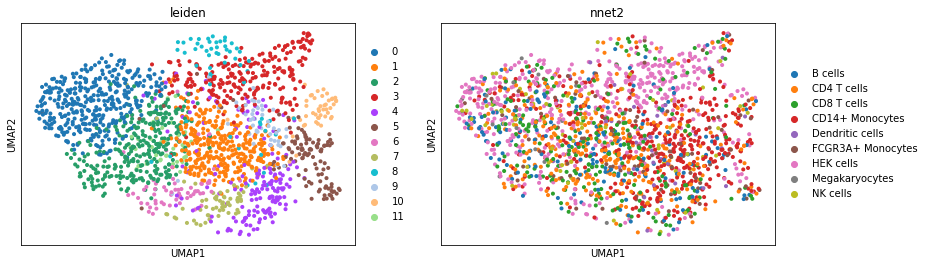

In [31]:
sc.pl.umap(adata,color=['leiden','nnet2'])

In [ ]:
schist.inference.nested_model(adata, equilibrate=False, deg_corr=True, steps_anneal=3,n_init=3)

In [ ]:
sc.pl.umap(adata,color=['nsbm_level2','nnet2'])